In [12]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import medfilt
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                nn.Dropout(),
                                nn.Linear(hidden_size,output_size))

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (h1, c1) = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [194]:
file_path = './data/ETTm2.csv'
data = pd.read_csv(file_path)
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001


In [195]:
temp = data.values[:,-1].astype(np.float64)
temp

array([38.66199875, 38.22299957, 37.34400177, ..., 45.54650116,
       45.54650116, 45.32699966])

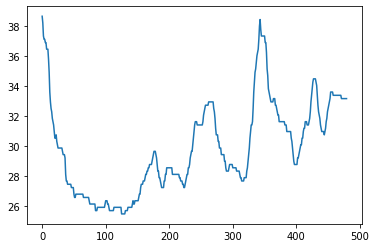

In [162]:
t1 = temp[:480]
plt.plot(t1, label='temp')

In [163]:
t2 = np.fft.fft(t1)
cp = 64
t3 = np.concatenate((t2[:cp],t2[-cp:]),axis=0)

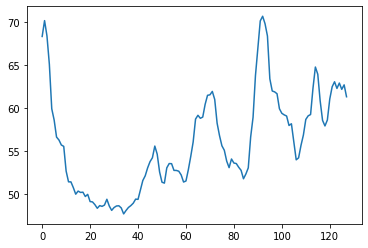

In [164]:
t4 = np.fft.ifft(t3)
plt.plot(t4.real/2)

In [168]:
def get_fft_factor(series,cutpoint=64):
    fft_result = np.fft(series)
    amplitudes = np.abs(fft_result)
    indices = np.argsort(amplitudes)[::-1][:cutpoint]  # 振幅最大的10个分量的索引
    top_components = np.zeros_like(fft_result)
    top_components[indices] = fft_result[indices]
    double_com = np.concatenate((top_components.real,top_components.imag),axis=0)
    return double_com

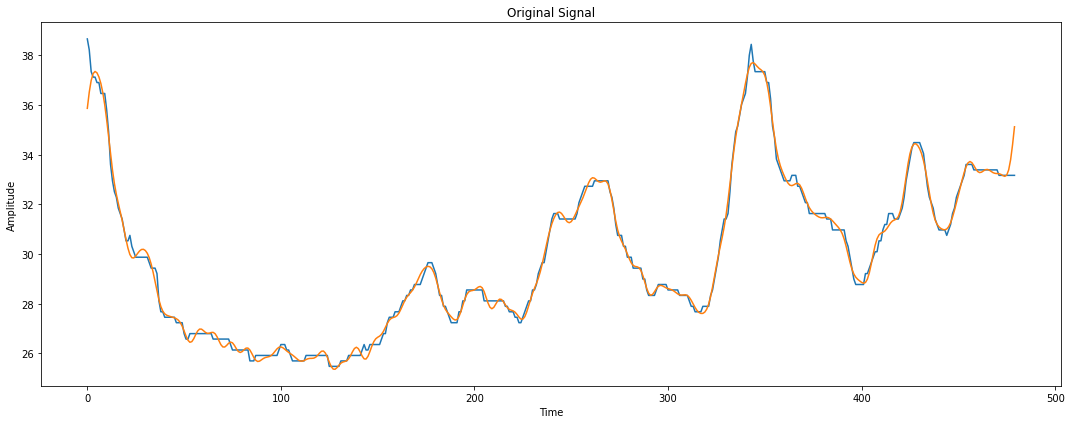

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft


# 执行傅里叶变换
fft_result = fft(t1)

# 计算振幅并提取最大的10个分量
cutpoint = 64
amplitudes = np.abs(fft_result)
indices = np.argsort(amplitudes)[::-1][:cutpoint]  # 振幅最大的10个分量的索引
top_components = np.zeros_like(fft_result)
top_components[indices] = fft_result[indices]

# 用这10个分量合成新的信号
new_signal = ifft(top_components)

# 绘制原始信号和重构的信号
plt.figure(figsize=(15, 6))


plt.plot(t1)
plt.title("Original Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")


plt.plot(new_signal.real)  # 取实部，因为ifft返回复数

plt.tight_layout()
plt.show()


In [189]:
np.sum((t1.real-new_signal.real)**2)/len(t1.real)

0.07030995530478244

In [170]:
top_components.shape

(480,)

In [175]:
temp = np.zeros((cutpoint,),dtype=np.complex128)
for i in range(len(indices)):
    temp[i] =fft_result[indices[i]]

In [178]:
temp2 = ifft(temp,)

f:\AnacondaBase\envs\ptl\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


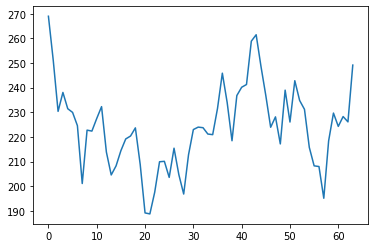

In [179]:
plt.plot(temp2)

In [199]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 创建一个简单的时间序列数据
np.random.seed(0)
data_points = 500
t = np.linspace(0, 10, data_points)
#signal = np.sin(t) + np.random.normal(0, 0.1, data_points)
#signal = signal.reshape(-1, 1)

signal = np.array(temp.reshape(-1, 1))
# 数据规范化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_signal = scaler.fit_transform(signal)

# 准备训练数据
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 96
X, Y = create_dataset(scaled_signal, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
aX = torch.from_numpy(X).float()
aY = torch.from_numpy(Y).float()
X = aX[:800]
Y= aY[:800]
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1][0]

# 实例化模型、定义损失函数和优化器
model = LSTMModel(input_size=1, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 150
for i in range(epochs):
    for seq, labels in zip(X, Y):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')



epoch:   1 loss: 0.00000449
epoch:  26 loss: 0.00032834
epoch:  51 loss: 0.00000373
epoch:  76 loss: 0.00000602
epoch: 101 loss: 0.00004231
epoch: 126 loss: 0.00000436


In [192]:
# 使用模型进行预测
model.eval()
with torch.no_grad():
    test_seq = X[-1:]
    preds = model(test_seq).item()

# 反规范化预测值
predicted_signal = scaler.inverse_transform([[preds]])

predicted_signal[0][0]  # 预测的下一个数据点

tensor(0.5591)